<a href="https://colab.research.google.com/github/mxpoch/PCF/blob/main/PCF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# key words:
# savings = constant
# none = reserved for root parent

In [8]:
import pandas as pd
import math
import matplotlib.pyplot as plt
class CashFlow:
    def __init__(self, gc, gsheet:str): 
        self.raw_inputnodes, self.raw_indextree = self.import_sheet(gc, gsheet)
        self.indexdict = self.build_index_tree(self.raw_indextree, self.raw_inputnodes)
        self.valuedict = self.build_input_nodes(self.raw_inputnodes)
        self.epoch = self.valuedict['epoch']['startdate']
        self.daymonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    def import_sheet(self, gc, gsheet:str) -> tuple:
        wb = gc.open_by_url(gsheet)
        read_inputnodes = wb.worksheet('InputNodes').get_all_values()
        read_indextree = wb.worksheet('IndexTree').get_all_values()

        raw_inputnodes = pd.DataFrame(read_inputnodes[1:], columns=read_inputnodes[0])
        # gspread imports everything as string, converting value and timeframe columns to numeric
        raw_inputnodes = raw_inputnodes.drop(columns=['value', 'period', 'percent', 'loanperiod']).join(raw_inputnodes[['value', 'period', 'percent', 'loanperiod']].apply(pd.to_numeric))

        raw_indextree = pd.DataFrame(read_indextree[1:], columns=read_indextree[0])
        return raw_inputnodes, raw_indextree

    def build_input_nodes(self, raw_inputnodes:pd.DataFrame()) -> dict:
        retdict = {}
        for i in range(raw_inputnodes.shape[0]):
            current = raw_inputnodes.iloc[i]
            retdict[current['name'].replace(' ', '')] = {col:current[col] for col in current.index if col != 'name'}
        return retdict

    def build_index_tree(self, raw_indextree:pd.DataFrame(), raw_inputnodes:pd.DataFrame()) -> dict:
        retdict = {}
        for i in range(raw_indextree.shape[0]):
            current = raw_indextree.iloc[i]
            children = raw_indextree[raw_indextree['parent'] == current['name']]
            node_children = raw_inputnodes[raw_inputnodes['parent'] == current['name']]
            
            if children.shape[0] == 0 and node_children.shape[0] == 0:
                retdict[current['name']] = 0
                continue

            children = children['name'].tolist()+node_children['name'].tolist()
            retdict[current['name']] = list(map(lambda x: x.strip(), children)) #cleans up any mistaken spaces
        
        return retdict    

    def generate_monthly(self, startdate:str, enddate:str) -> list:
        gendates = [startdate]
        currentdate = '00000000'
        m = int(startdate[:2])
        y = int(startdate[4:])
        # end of month edge-case
        if int(startdate[2:4]) in self.daymonth:
            while currentdate != enddate:
                m += 1
                m = m % 12
                if m == 0: m = 12
                if m == 1: y += 1

                d = int(self.daymonth[m])
                if d < 10: d = '0'+str(d)
                
                month = ''
                if m < 10: month = '0'+str(m)
                else: month = str(m)

                currentdate = month+d+str(y)
                gendates.append(currentdate)
        else:
            while currentdate != enddate:
                m += 1
                m = m % 12
                if m == 0: m = 12
                if m == 1: y += 1

                month = ''
                if m < 10: month = '0'+str(m)
                else: month = str(m)
                
                currentdate = month+startdate[2:4]+str(y)
                gendates.append(currentdate)

        gendates.append(enddate)
        return gendates

    def single(self, name:str, date:str) -> float:
        if date != self.valuedict[name]['startdate']: return 0
        else: return self.valuedict[name]['value']
    
    def recurring(self, name:str, date:str) -> float:
        generated_dates = []
        startdate = self.valuedict[name]['startdate']
        enddate = self.valuedict[name]['enddate']
        period = self.valuedict[name]['period']

        if period == -1: generated_dates = self.generate_monthly(startdate, enddate)
        else: generated_dates = [gendate for gendate in self.generate_dates(startdate, enddate, int(period))]

        if date in generated_dates: return self.valuedict[name]['value']
        else: return 0

    def calculate_payment(self, name:str, date:str) -> float:
        paymenttype = self.valuedict[name]['paymenttype']
        if paymenttype.strip() == 'recurring':
            # calculates only if date is on payment day
            return self.recurring(name, date)
        if paymenttype.strip() == 'single':
            # calculates only if date is equal to payment day
            return self.single(name, date)

        # loans disabled until loan calculator is built
        # if paymenttype.strip() == 'loansimple':
        #     # calculates payment amount for simple interest loan 
        #     # payment amount is based on start/end dates per payment period
        #     return self.loansimple(name, date)
        # if paymenttype.strip() == 'loancompound':
        #     # calculates payment amount for compounding interst loan
        #     return self.loancompound(name, date)
        else: 
            return 0

    def find_timeframe(self, startdate:str, enddate:str) -> int:
        startday = sum(self.daymonth[:int(startdate[:2])-1]) + int(startdate[2:4])
        endday = sum(self.daymonth[:int(enddate[:2])-1]) + int(enddate[2:4]) + (365*(int(enddate[4:])-int(startdate[4:])))
        return endday-startday

    def find_overlap_time(self, date:str, name:str) -> int:
        # checks for overlap with the current date
        # maximum value
        localframe = self.find_timeframe(self.valuedict[name]['startdate'], self.valuedict[name]['enddate'])
        currentday = self.find_timeframe(self.valuedict[name]['startdate'], date)
        if currentday < 0 or currentday > localframe: return -1
        else: return currentday

    def sum_all_worker(self, name:str, currentsum:list, date:str):
        if name not in self.indexdict.keys():
            if name == 'savings': return # calculated later
            else: currentsum[0] += round(self.calculate_payment(name, date), 2)
            return 

        # if type(self.indexdict[name]) == int: return 
        for next in self.indexdict[name]:
            self.sum_all_worker(next, currentsum, date)
    
    def sum_all(self, name:str, date:str) -> int:
        currentsum = [0] # necessary to pass by reference in python
        self.sum_all_worker(name, currentsum, date)
        return round(float(currentsum[0]), 2)

    def pretty_worker(self, name:str, recurdepth:int):
        if name not in self.indexdict.keys(): 
            print("   "*recurdepth, name, '|',self.valuedict[name]['paymenttype'])
            return 
        print("   "*recurdepth, name)
        for next in self.indexdict[name]:
            try:
                self.pretty_worker(next, recurdepth+1)
            except TypeError:
                pass
    
    def displaycosts(self):
        print('Nodes per Month:')
        self.pretty_worker('root', 0) 

    def positive_floor(self, number:int) -> int:
        if number < 0: return -1
        else: return number

    def date_increment(self, date:str, increment:int) -> str:
        # convert whole thing into days since start, then convert back
        # day 0 is new year's day of current year
        currentday = sum(self.daymonth[:(int(date[:2])-1)]) + int(date[2:4]) -1 
        currentday += increment

        yeardisplacement = math.floor(currentday/365)
        year = int(date[4:])+yeardisplacement

        currentday %= 365   

        monthsums = [currentday-sum(self.daymonth[:x]) for x in range(12) if currentday-sum(self.daymonth[:x]) >= 0]
        day = min(monthsums)+1
        month = monthsums.index(min(monthsums))+1

        if month < 10: month = '0'+str(month)
        if day < 10: day = '0'+str(day)
        return str(month)+str(day)+str(year)
    
    def generate_dates(self, startdate:str, enddate:str, timeskip:int) -> list:
        cday = self.date_increment(startdate, -1)
        max = int(math.floor(self.find_timeframe(cday, enddate) / timeskip))
        for x in range(max):
            cday = self.date_increment(cday, timeskip)
            yield cday

    def visualize_range(self, sections:list, startdate:str, enddate:str, timeskip:int):
        dates = [t for t in self.generate_dates(startdate, enddate, timeskip)]
        savings = self.valuedict['savings']['value'] 

        plt.figure(figsize=(30,10))
        for section in sections:
            currentsavings = savings.copy()
            datapoints = []
            for t in self.generate_dates(self.epoch, enddate, 1):
                current = self.sum_all(section, t)
                if current != float(0):
                    datapoints.append(currentsavings)
                    currentsavings += current
                else: 
                    datapoints.append(currentsavings)
            
            start_offset = self.find_timeframe(self.epoch, startdate)
            if start_offset < 0:
                raise ValueError(f'Cannot input a date before the start of epoch: {startdate}, {enddate}')

            adj_dp = [datapoints[(dp*timeskip)+start_offset] for dp in range(len(dates))]
            plt.plot(dates, adj_dp, label=section)
        
        title = sections[0]
        if len(sections) > 1: title = ' vs '.join(sections)
        plt.title(title)
        plt.xticks(rotation=45)
        plt.ylabel('$CAD')
        plt.xlabel('date')
        plt.legend()
        plt.show()

In [9]:
# authenticator
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [14]:
gsheet = 'Google Sheet Goes Here'
CF = CashFlow(gc, gsheet)

In [15]:
CF.displaycosts()

Nodes per Month:
 root
    Education
       OSAP
          OSAPGrant-Year1Term1 | single
          OSAPLoan-Year1Term1 | single
          OSAPGrant-Year1Term2 | single
          OSAPLoan-Year1Term2 | single
       Awards&Grants
          UWEntranceBursary | single
          UWPresidentsScholarship | single
          Allowance | recurring
       Tuition
          Tuition-Term1 | single
       Books | single
    Living
       Residence
          REVDorm-Year1Term1 | single
          REVDorm-Year1Term2 | single
       MealPlan | recurring
    Entertainment
       SocialCapital | recurring
    savings | single
    epoch | single


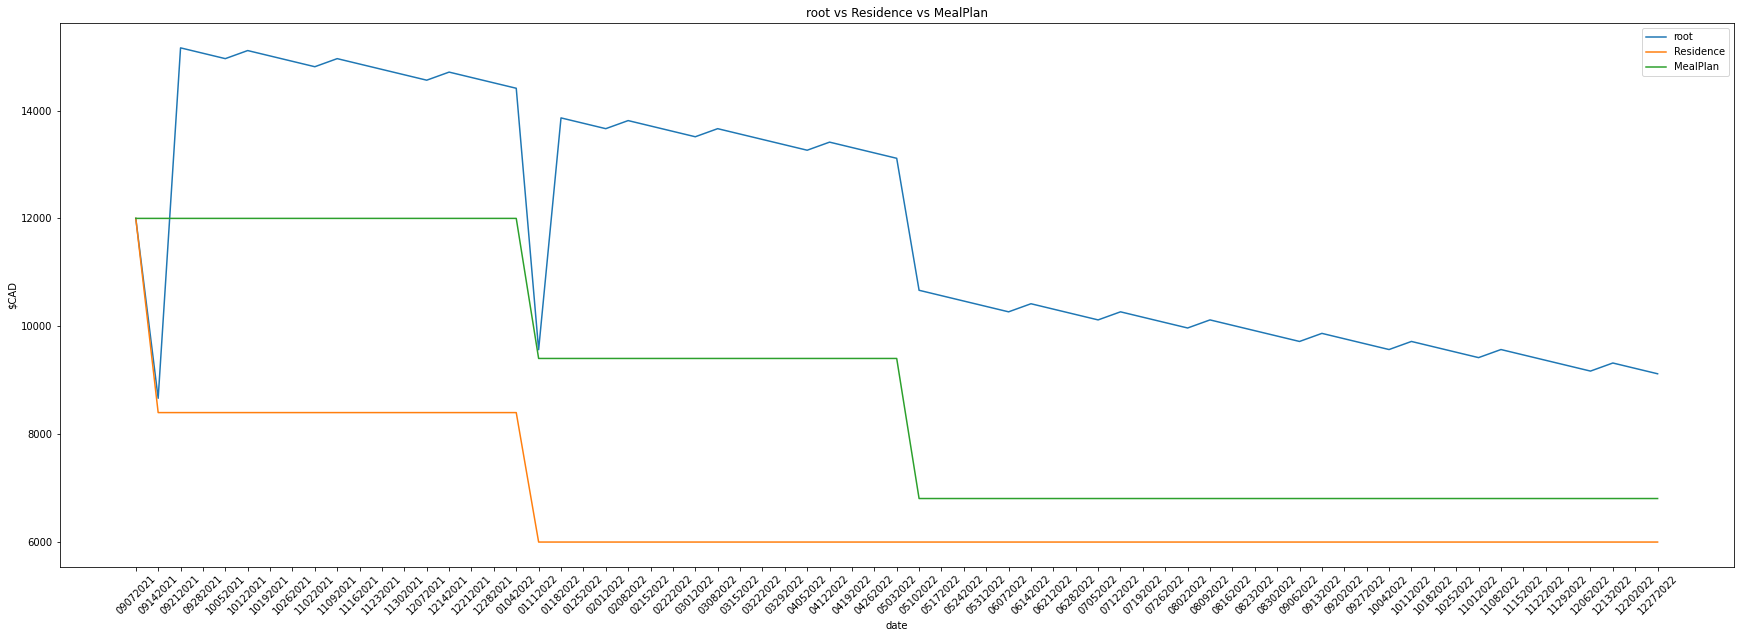

In [16]:
CF.visualize_range(['root', 'Residence', 'MealPlan'], '09012021', '01012023', 7)